# 01 Creation of the first bell state

This Jupyter notebook provides a practical guide to help ypur understanding of the basics to write quantum algorithms using Qiskit. 
Our objective is to create a bell state or an ERP Pair (Einstein, Podolsky, Rosen pair) which essentially refers to a pair of qubits that are maximally entangled. In this notebook, we are going to implement the bell state below

![bell_state_1.png](bell_state_1.png)

This state can be implemented using a two qubit circuit consisting of a Hadamard gate and CNOT gate. In the circuit shown above, CNOT gate forces the second qubit to have same value as the first qubit, creating a maximally entangled state; an EPR pair


## Step 0 : Importing necessary libraries

In [1]:
import qiskit
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService

In [2]:
qiskit.__version__

'1.1.1'

this section, you only have to set up once

In [ ]:
service = QiskitRuntimeService(channel="ibm_quantum", # ibm_cloud 
                               token = 'YourAPIToken')

In [ ]:
# save the account here if you don't want to log in again
QiskitRuntimeService.save_account(channel="ibm_quantum", # ibm_cloud 
                               token = 'YourAPIToken')

After saving the account, try initiating the service without the API token

In [3]:
service = QiskitRuntimeService()

In [4]:
backend = service.backend(name = "ibm_brisbane")

In [5]:
backend.num_qubits

127

## Step 1 : Define a circuit

To create the bell state, we need two qubits. In addition, we will store the result of the circuit execution in a classical bit

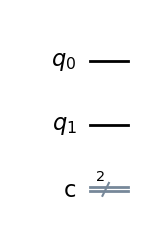

In [6]:
qc = QuantumCircuit(2,2) #create a quantum circuit with two quibit and two classical bit
qc.draw('mpl') #visualize the circuit

## Step 2 : Applying gates

After we initializ the circuit, we need to apply two gates :
+ A Hadamard gate (H) : 
+ A controlled NOT gate (CNOT)

The Hadamard gate is a unary gate because it operates on just one qubit. <br />
The CNOT gate operates on two qubits, making it a gate of arity 2

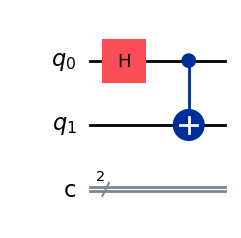

In [7]:
qc.h(0) #add Hadamard gate
qc.cx(0, 1) #add CNOT gate
qc.draw("mpl")


Now the circuit is ready to be executed on a simulator! :D

## Step 3: Printing the information of the circuit

In [8]:
print("Number of qubits: ", qc.num_qubits)
print("Number of classical bits: ", qc.num_clbits)
print("Circuit depth: ", qc.depth())

Number of qubits:  2
Number of classical bits:  2
Circuit depth:  2


## Step 4 : Run the circuit on a simulator

In this section, we are going to use first the [StatevectorSimulator](https://qiskit.github.io/qiskit-aer/stubs/qiskit_aer.StatevectorSimulator.html#qiskit_aer.StatevectorSimulator) from qiskit_aer to visualize the resulting state vector


In [9]:
from qiskit_aer import StatevectorSimulator

simulator_aerlegacy = StatevectorSimulator()
result_aerlegacy = simulator_aerlegacy.run(qc).result()

In [10]:
psi = result_aerlegacy.get_statevector()

In [11]:
display(psi.draw(output='latex'))  #writing the results in latex 

<IPython.core.display.Latex object>

The result demonstrates that the states $|00\rangle$ and $|11\rangle$ are equally likely to be measured.  Other states, such as $|01\rangle$ or $|10\rangle$, have zero probability of being measured in an ideal scenario without noise.

This section below shows how we can run the circuit on Aer simulator without any noise model

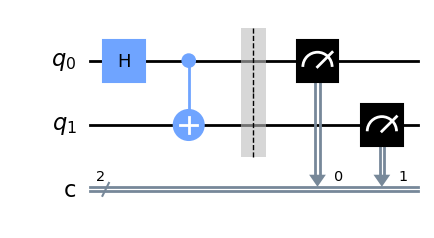

In [12]:
import qiskit 
from qiskit import transpile
from qiskit_aer import AerSimulator

# Construct an ideal simulator
simulator = AerSimulator()
qc.measure_all(add_bits=False)
qc.draw('mpl',style='clifford')


In [13]:
circ = transpile(qc,simulator) # Transpile for simulator
sim_result = simulator.run(circ, simulator=1024).result()


In [14]:
counts = sim_result.get_counts()

In [15]:
experiment = sim_result._get_experiment()

for sample in counts:
    print(f"Measurement: {sample}, Hits: {counts[sample]}, Probability: {counts[sample]/experiment.shots}")

Measurement: 00, Hits: 522, Probability: 0.509765625
Measurement: 11, Hits: 502, Probability: 0.490234375


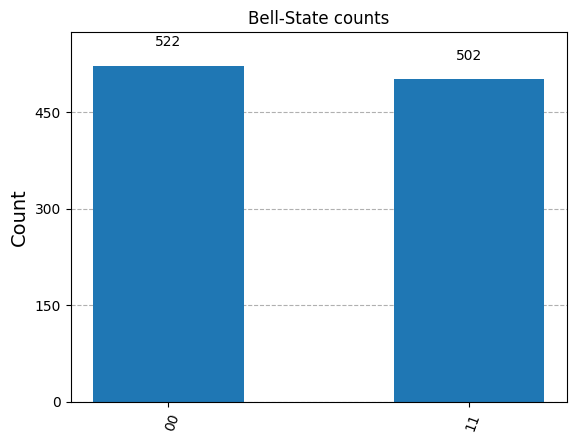

In [16]:
# Let's visualize with histograms!
from qiskit.visualization import plot_histogram
plot_histogram(counts, title='Bell-State counts')

## Step 5 : Eexcute it on real hardware!

In [17]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Set up qiskit runtume service, we choose the backend with the least queue :D
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=2) 
transpiled_qc = transpile(qc,backend)

In [19]:
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_circuit = pm.run(transpiled_qc)

In [20]:
sampler = Sampler(mode=backend)

now we are sending the job to queue on the hardware with 1024 shots. if you need to cancel the job, use job.cancel()

In [21]:
job = sampler.run([isa_circuit],shots=1024)
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: ctf2rs3xgmhg0084xqq0
>>> Job Status: QUEUED


In [ ]:
# job.result() only available when the job is completed
job_result = job.result()
real_counts = job_result[0].data.c.get_counts()

In [ ]:
plot_histogram(real_counts, title='Bell-State counts')

In [ ]:
data = [
  counts, # simulator results
  real_counts, # real hardware results
]
legend = ['Simulator', 'IBM QPU']
title = 'Comparison Simulator vs. IBM QPU'

plot_histogram(data, title=title, legend=legend)

Let's compare the simulator's results with those obtained from the IBM QPU. The simulator, being an ideal state, will never yield measurements for states $|01\rangle$ and $|10\rangle$. However, the IBM QPU, as a real-world quantum device, is susceptible to noise. This noise may show as non-zero counts for  $|01\rangle$ and $|10\rangle$, with the extent of these deviations depending on the current calibration quality of the device.